# Пример 2, обучение трансформера TabNet выявлению сепсиса

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Устройство MIMIC
В примерах разберем, как с помощью модуля sickness-screening обучить модель предсказывать сепсис на наборе данных MIMIC.
В MIMIC есть множество таблиц, но для примера нам потребуются следующие таблицы:
1. **chartevents.csv** —— содержит данные мониторинга пациентов, например: температура тела, артериальное давление.
2. **drgcodes.csv** —— содержит информацию о диагнозах, которые получил пациент.

### Установим библиотеку

In [ ]:
!pip install sickness-screening

##### Импортирование библиотеки

In [3]:
import sickness_screening as ss

### Соберем датасет на основе признаков из MEWS:
*   Систолическое артериальное давление
*   Частота сердцебиения
*   Частота дыхательных движений
*   Температура

In [ ]:
item_ids = [str(x) for x in [225309, 220045, 220210, 223762]]
file_path = './MIMIC/icu/chartevents.csv'
output_path = 'df.csv'

ss.process_chartevents(file_path, output_path, item_ids)

Добавим таргет к нашему датасету - болен человек или нет

In [ ]:
drgcodes_path = './MIMIC/hosp/drgcodes.csv'
merged_data_path = './df.csv'
output_path = 'df_with_target.csv'

ss.add_diagnosis_column(drgcodes_path, merged_data_path, output_path)

### Заполним пропуски

In [ ]:
input_path = 'df_with_target.csv'
output_path = 'df_with_target_imputed.csv'
features = ['225309', '220045', '220210', '223762']

ss.impute_data(input_path, output_path, features)

### Разделим наш датасет на тренировочную и тестовую выборки. Затем сбалансируем тренировочный набор данных

In [ ]:
input_path = 'df_with_target_imputed.csv'
test_size = 0.4
random_state = 42
features = ['225309', '220045', '220210', '223762']
target = 'SepsisLabel'
resampled_output_path = 'train_data_MEWS.csv'
test_output_path = 'test_data.csv'

df_resampled, test_data = ss.prepare_and_save_data(input_path, test_size, random_state, features, target, resampled_output_path, test_output_path)

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Лаба ML/transformers/train_data_MEWS.csv')

Проверим, что у нас нет дисбаланса в данных

In [7]:
print(sum(df['diagnosis'] == 0))
print(sum(df['diagnosis'] == 1))

27249
27249


### Разделим тестовый набор данных на валидационную и тестовую выборки, и сбалансируем их

In [ ]:
input_path = 'test_data.csv'
test_size = 0.4
random_state = 42
features = ['225309', '220045', '220210', '223762']
target = 'diagnosis'
test_output_path = 'test_resampled_data.csv'
val_output_path = 'val_resampled_data.csv'

ss.resample_test_val_data(input_path, test_size, random_state, features, target, test_output_path, val_output_path)

Проверим, что в валидационном и тестовом наборах не дисбаланса классов

In [9]:
df = pd.read_csv('/content/drive/MyDrive/Лаба ML/transformers/val_resampled_data_MEWS.csv')

In [10]:
print(sum(df['diagnosis'] == 0))
print(sum(df['diagnosis'] == 1))

9128
9128


In [11]:
df = pd.read_csv('/content/drive/MyDrive/Лаба ML/transformers/test_resampled_data_MEWS.csv')

In [12]:
print(sum(df['diagnosis'] == 0))
print(sum(df['diagnosis'] == 1))

9065
9065


### Далее обучим модель с выбранными гиперпараметрами, сохраним важность признаков

In [13]:
train_path = '/content/drive/MyDrive/Лаба ML/transformers/train_data_MEWS.csv'
val_path = '/content/drive/MyDrive/Лаба ML/transformers/val_resampled_data_MEWS.csv'
feature_importances_path = 'fimp.txt'
model_save_path = './tabnet_model_test_1'
optimizer_params = dict(lr=0.05)
scheduler_params = {
    "milestones": [10, 20, 30],
    "gamma": 0.9
}

ss.train_tabnet_model(train_path, val_path, feature_importances_path, model_save_path, optimizer_params, scheduler_params, pretraining_lr=0.05, training_lr=0.05, mask_type='sparsemax', pretraining_ratio=1.0, max_epochs=200, patience=50)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68239 | val_0_auc: 0.40872 |  0:00:03s
epoch 1  | loss: 0.66268 | val_0_auc: 0.50621 |  0:00:06s
epoch 2  | loss: 0.65959 | val_0_auc: 0.54198 |  0:00:09s
epoch 3  | loss: 0.65933 | val_0_auc: 0.57445 |  0:00:11s
epoch 4  | loss: 0.65824 | val_0_auc: 0.59443 |  0:00:14s
epoch 5  | loss: 0.65685 | val_0_auc: 0.59336 |  0:00:19s
epoch 6  | loss: 0.65488 | val_0_auc: 0.5931  |  0:00:22s
epoch 7  | loss: 0.65557 | val_0_auc: 0.58179 |  0:00:24s
epoch 8  | loss: 0.653   | val_0_auc: 0.59108 |  0:00:27s
epoch 9  | loss: 0.65346 | val_0_auc: 0.58355 |  0:00:30s
epoch 10 | loss: 0.65359 | val_0_auc: 0.58407 |  0:00:33s
epoch 11 | loss: 0.6532  | val_0_auc: 0.5923  |  0:00:36s
epoch 12 | loss: 0.65292 | val_0_auc: 0.59004 |  0:00:39s
epoch 13 | loss: 0.65234 | val_0_auc: 0.58173 |  0:00:42s
epoch 14 | loss: 0.65362 | val_0_auc: 0.58971 |  0:00:45s
epoch 15 | loss: 0.65249 | val_0_auc: 0.59169 |  0:00:48s
epoch 16 | loss: 0.65185 | val_0_auc: 0.5866  |  0:00:51s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./tabnet_model_test_1.zip


### Посмотрим на важность признаков в трансформера

In [14]:
file_path = '/content/fimp.txt'

with open(file_path, 'r') as file:
    content = file.read()
    print(content)

[0.23699013 0.32132814 0.26303686 0.17864487]


Визуализируем важность признаков

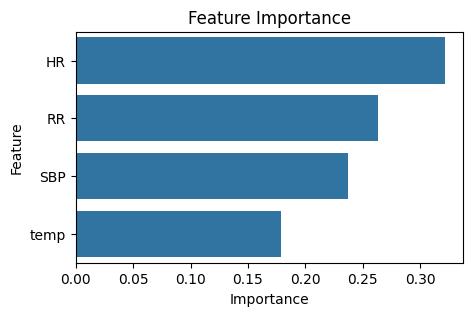

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = [0.23699013, 0.32132814, 0.26303686, 0.17864487]

importance_df = pd.DataFrame({'Feature': ['SBP','HR','RR','temp'], 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(5, 3))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Посмотрим метрики на тестовой выборке

In [18]:
model_path = "./tabnet_model_test_1.zip"
test_data_path = '/content/drive/MyDrive/Лаба ML/transformers/test_resampled_data_MEWS.csv'
metrics_output_path = "metrics.txt"

ss.evaluate_tabnet_model(model_path, test_data_path, metrics_output_path)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [20]:
file_path = '/content/metrics.txt'

with open(file_path, 'r') as file:
    content = file.read()
    print(content)

Accuracy: 0.5236072807501378
Precision: 0.5132115075935301
Recall: 0.9170435741864313
F1-score: 0.6581166132288327



### Предскажем, болен человек или нет

In [ ]:
!pip install pytorch_tabnet

In [22]:
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np

Новый образец 1

In [25]:
X_next = pd.DataFrame({
    '225309' : [120.0],
    '220045' : [99.0],
    '220210' : [20.0],
    '223762' : [36.8]
})

loaded_clf = TabNetClassifier()
loaded_clf.load_model(model_path)
result = loaded_clf.predict(X_next.values)

In [26]:
diagnosis_message = "Здоров" if result[0] == 0 else "Болен"
print(f"Диагноз: {diagnosis_message}")

Диагноз: Болен


Новый образец 2

In [91]:
X_next = pd.DataFrame({
    '225309' : [np.nan],
    '220045' : [70.0],
    '220210' : [17.0],
    '223762' : [np.nan]
})

loaded_clf = TabNetClassifier()
loaded_clf.load_model(model_path)

X_next_filled = X_next.fillna(-100000)

result = loaded_clf.predict(X_next_filled.values)

In [92]:
diagnosis_message = "Здоров" if result[0] == 0 else "Болен"
print(f"Диагноз: {diagnosis_message}")

Диагноз: Здоров
